In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict, cross_validate, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()


df_normal_quality = pd.read_csv('df_normal_quality.csv', index_col= 0).reset_index(drop = True)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)

# Lasso Tuned Model

In [221]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = Lasso(alpha = 0.00030733929099045147),
                                                                func =np.log, inverse_func=np.exp))])

scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

print('score', scores.mean())
print('standard deviation', scores.std())

lasso_pipe.fit(X,y)

predictions = lasso_pipe.predict(X)
print('predicted prices', predictions)
mae = mean_absolute_error(y, predictions)
print('Mean Absolute Error:', mae)
mpv = predictions.mean()
print ('Mean Predicted Home Value', mpv)
mhv = y.mean()
print ('Mean  Home Value', mhv)


score 0.9508124989217249
standard deviation 0.004995040204432598
predicted prices [125417.29914791 130118.74949454 115891.54733895 ... 153058.38303178
 224554.74105895 223794.23727269]
Mean Absolute Error: 10280.912930379654
Mean Predicted Home Value 172914.8587998538
Mean  Home Value 173427.01285897984


In [223]:
lasso_predictions = lasso_pipe.predict(X)
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': lasso_predictions - y
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title='GrLivArea vs. Error',
    labels={'GrLivArea': 'GrLivArea (Square Feet)', 'Error': 'Prediction - Sale Price ($)', 'OverallQual': 'Overall Quality'}
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))

# Show plot
fig.show()


In [158]:
y[530]

230000

In [166]:
X.loc[X.GrLivArea == 1295].loc[X.OverallQual == 49].Neighborhood

530    GrnHill
Name: Neighborhood, dtype: object

# Feature Importance
### lasso tuned model

In [1]:
lasso_pipe.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
lasso_regressor = lasso_pipe.named_steps['Regressor'].regressor_
coefficients = lasso_regressor.coef_

# Get the feature names after preprocessing
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_lasso = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': coefficients})

# Sort the DataFrame by importance
feature_importance_lasso = feature_importance_lasso.sort_values(by='Importance', ascending=False)


feature_importance_lasso['Feature'] = feature_importance_lasso['Feature'].str.replace('robust_scaler__', '', regex=False)
feature_importance_lasso['Feature'] = feature_importance_lasso['Feature'].str.replace('one-hot-encoder__', 'OHE__', regex=False)
feature_importance_lasso.head(20)

NameError: name 'lasso_pipe' is not defined

In [22]:
feature_importance_lasso.loc[feature_importance_lasso.Importance == 0]

Feature  Importance
135        OHE__RoofMatl_Roll         0.0
160  OHE__Exterior2nd_ImStucc        -0.0
161  OHE__Exterior2nd_MetalSd        -0.0
132     OHE__RoofMatl_CompShg        -0.0
134       OHE__RoofMatl_Metal         0.0
..                        ...         ...
103      OHE__Condition1_RRAn         0.0
126       OHE__RoofStyle_Flat         0.0
102      OHE__Condition1_RRAe        -0.0
100      OHE__Condition1_PosA         0.0
105      OHE__Condition1_RRNn        -0.0

[124 rows x 2 columns]

# Lasso SHAP
### One hot encoded categories left apart 

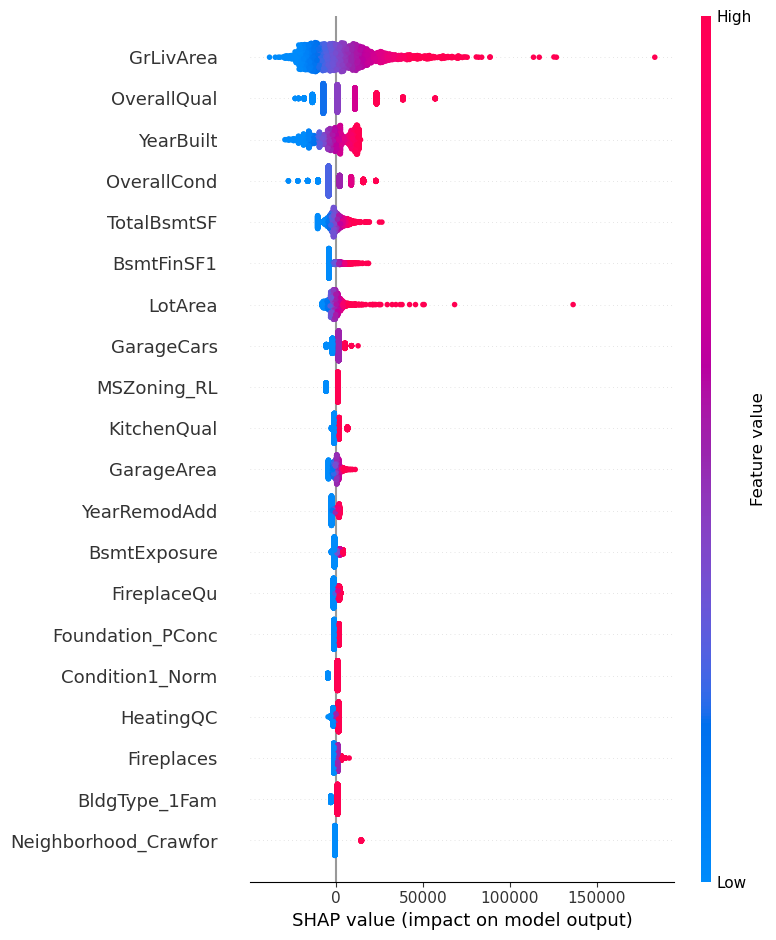

In [23]:
explainer_lasso = shap.Explainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lasso = explainer_lasso(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso = pd.DataFrame(shap_values_lasso.values, columns=transformed_feature_names)

bv = shap_values_lasso.base_values[0]
dollar_shap_values_lasso = np.exp(bv + shap_values_df_lasso) - np.exp(bv)
    
# Get rid of prefixes
dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

df_lasso = pd.DataFrame(lasso_pipe.named_steps['Preprocess'].transform(X))
df_lasso.columns = dollar_shap_values_lasso.columns
df_lasso[numerical_columns] = X[numerical_columns]
df_lasso
# Create a shap.Explanation with scaled shap values and correct feature names 
exp_all_lasso = shap.Explanation(dollar_shap_values_lasso.values, 
                       np.exp(shap_values_lasso.base_values),
                       df_lasso)

shap.summary_plot(exp_all_lasso)

# Lasso SHAP
### Features combined

In [145]:
# Create a SHAP explainer for the Lasso model
explainer_lasso_comb = shap.Explainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lasso_comb = explainer_lasso_comb(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso_comb = pd.DataFrame(shap_values_lasso_comb.values, columns=transformed_feature_names)

# correct categorical prefixes so encoded variables can be combined"
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_lasso_comb[prefix] = shap_values_df_lasso_comb[columns].mean(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_lasso_comb.drop(columns=columns, inplace=True)

# find the base_value and use it to convert shap values back to dollars
# Use this to find the dollar value home with just that particular feature
# the subtract the bv of the home to see the exact value for that feature 
bv = shap_values_lasso_comb.base_values[0]
dollar_shap_values_lasso_comb = np.exp(bv + shap_values_df_lasso_comb) - np.exp(bv)
    
# Get rid of prefixes
dollar_shap_values_lasso_comb.columns = dollar_shap_values_lasso_comb.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
dollar_shap_values_lasso_comb.columns = dollar_shap_values_lasso_comb.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# reorder X columns so the original values are in the same order as the shap df
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]

# Create a shap.Explanation with scaled shap values and correct feature names 
exp_lasso_comb = shap.Explanation(dollar_shap_values_lasso_comb.values, 
                       np.exp(shap_values_lasso_comb.base_values),
                       X_new_order)

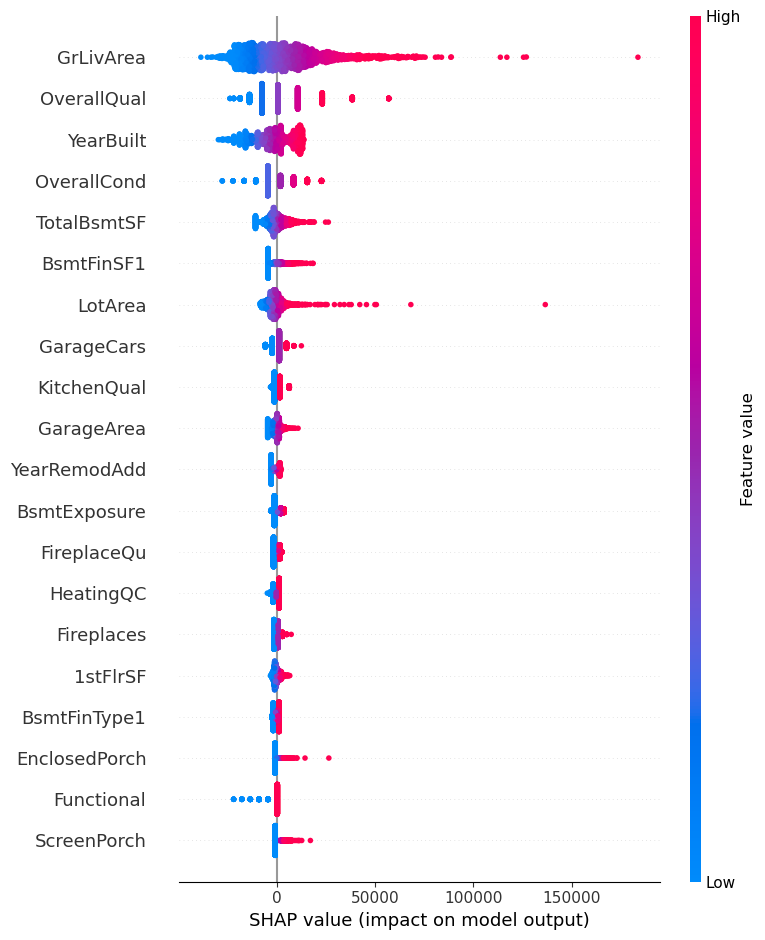

In [146]:
shap.summary_plot(exp_lasso_comb)

In [220]:
fig = px.scatter(
    x=X.Neighborhood, 
    y=dollar_shap_values_lasso_comb.Neighborhood, 
    color = np.sqrt(X.OverallQual),
    labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
    title='Overall Quality vs Neighborhood SHAP Values'
)

fig.show()

# Elastic Net Tuned

In [25]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

numerical_preprocessor = RobustScaler()

preprocessor = ColumnTransformer(
    [
        ("robust-scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

en_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = ElasticNet(alpha =  0.0006921322276640134, 
                                                                                             l1_ratio= 0.4415555448483296),
                                                                func =np.log, inverse_func=np.exp))])

scores = cross_val_score(en_pipe, X, y, cv = kf, error_score='raise')

print('score', scores.mean())
print('standard deviation', scores.std())

en_pipe.fit(X,y)

predictions = en_pipe.predict(X)
print('predicted prices', predictions)
mae = mean_absolute_error(y, predictions)
print('Mean Absolute Error:', mae)
mpv = predictions.mean()
print ('Mean Predicted Home Value', mpv)
mhv = y.mean()
print ('Mean Home Value', mhv)

score 0.9508214083737423
standard deviation 0.004985053272069941
predicted prices [125475.81711939 130153.76501542 116515.81539284 ... 152799.98807441
 224567.63343166 223908.2101553 ]
Mean Absolute Error: 10285.25533649989
Mean Predicted Home Value 172909.30936918728
Mean Home Value 173427.01285897984


# Feature Importance
### EN Tuned Model

In [26]:
en_pipe.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
en_regressor = en_pipe.named_steps['Regressor'].regressor_
coefficients = en_regressor.coef_

# Get the feature names after preprocessing
transformed_feature_names = en_pipe.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_en = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': coefficients})

# Sort the DataFrame by importance
feature_importance_en = feature_importance_en.sort_values(by='Importance', ascending=False)


feature_importance_en['Feature'] = feature_importance_en['Feature'].str.replace('robust_scaler__', '', regex=False)
feature_importance_en['Feature'] = feature_importance_en['Feature'].str.replace('one-hot-encoder__', 'OHE__', regex=False)
feature_importance_en.head(20)

Feature  Importance
0      robust-scaler__GrLivArea    0.161166
9    robust-scaler__OverallQual    0.113950
11     robust-scaler__YearBuilt    0.094208
75    OHE__Neighborhood_Crawfor    0.090777
93    OHE__Neighborhood_Somerst    0.055874
142    OHE__Exterior1st_BrkFace    0.051185
60             OHE__MSZoning_RL    0.043555
20    robust-scaler__BsmtFinSF1    0.042657
10   robust-scaler__OverallCond    0.040708
99         OHE__Condition1_Norm    0.035453
24   robust-scaler__TotalBsmtSF    0.031348
37    robust-scaler__Functional    0.030023
88    OHE__Neighborhood_NridgHt    0.028458
57             OHE__MSZoning_FV    0.028254
72    OHE__Neighborhood_BrkSide    0.025759
113          OHE__BldgType_1Fam    0.025078
3        robust-scaler__LotArea    0.023625
41    robust-scaler__GarageCars    0.022662
25     robust-scaler__HeatingQC    0.019449
73    OHE__Neighborhood_ClearCr    0.019430

# Elastic Net SHAP

In [27]:
explainer_en = shap.Explainer(en_pipe.named_steps['Regressor'].regressor_,
                          masker = en_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_en = explainer_en(en_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = en_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_en = pd.DataFrame(shap_values_en.values, columns=transformed_feature_names)

bv = shap_values_en.base_values[0]
dollar_shap_values_en = np.exp(bv + shap_values_df_en) - np.exp(bv)
    
# Get rid of prefixes
dollar_shap_values_en.columns = dollar_shap_values_en.columns.str.replace('robust-scaler__', 
                                                                    '', 
                                                                    regex=False)
dollar_shap_values_en.columns = dollar_shap_values_en.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

df_en = pd.DataFrame(en_pipe.named_steps['Preprocess'].transform(X))
df_en.columns = dollar_shap_values_en.columns
df_en[numerical_columns] = X[numerical_columns]

# Create a shap.Explanation with scaled shap values and correct feature names 
exp_all_en = shap.Explanation(dollar_shap_values_en.values, 
                      np.exp(shap_values_en.base_values),
                      df_en)



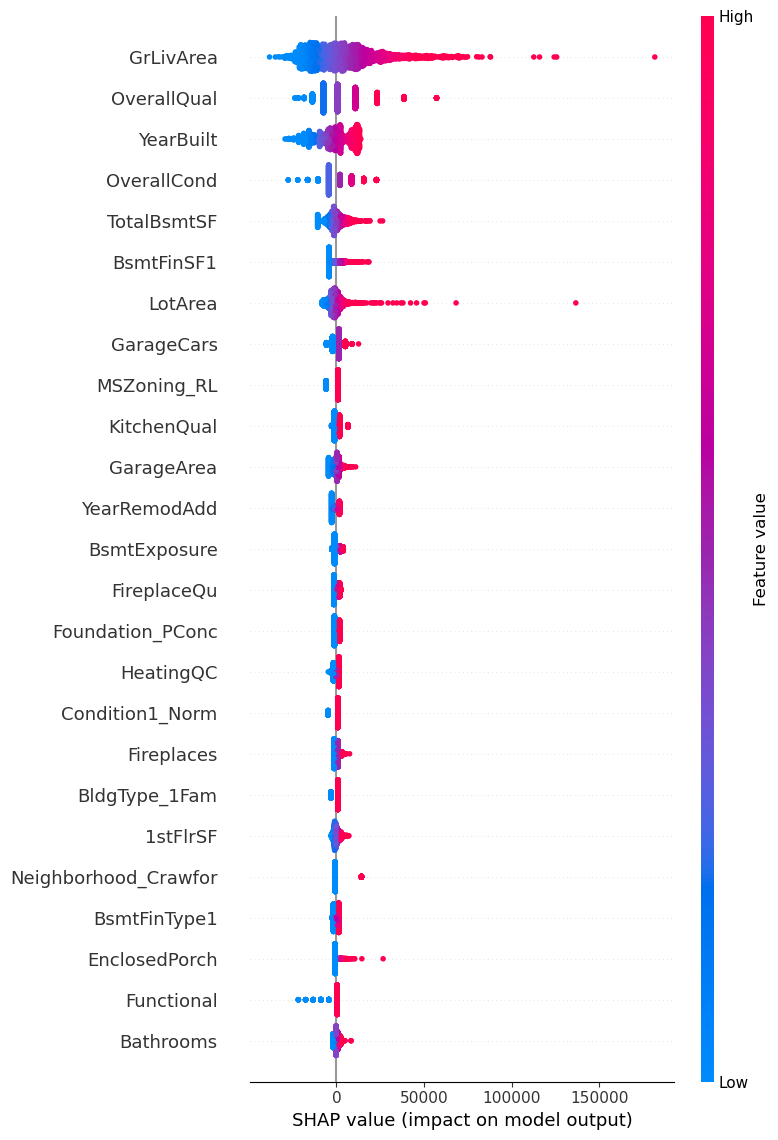

In [28]:
shap.summary_plot(exp_all_en, max_display= 25)

# XGBoost Tuned 

In [19]:
categorical_preprocessor_OHE = OneHotEncoder(handle_unknown="ignore", drop = 'first')
categorical_preprocessor_O =  OrdinalEncoder(handle_unknown="use_encoded_value", 
                                           unknown_value= -1)
numerical_preprocessor = StandardScaler()

preprocessor_OHE = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_OHE, categorical_columns),
    ]
)

preprocessor_O = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_O, categorical_columns),
    ]
)


xgb =  XGBRegressor(max_depth= 3,
                    learning_rate= 0.03948737640519406,
                    subsample= 0.3203617673528298,
                    colsample_bytree= 0.9678010901635519,
                    n_estimators= 1000,
                    min_child_weight= 2)

xgb_pipe_OHE = Pipeline(steps=[("Preprocess", preprocessor_OHE), ("XGB", xgb)])

xgb_pipe_O = Pipeline(steps=[("Preprocess", preprocessor_O), ("XGB", xgb)])


scores_OHE = cross_val_score(xgb_pipe_OHE, X, y, cv = kf, error_score='raise')

scores_O = cross_val_score(xgb_pipe_O, X, y, cv = kf, error_score='raise')


print('XGB OneHot')
print('score', scores_OHE.mean())
print('standard deviation', scores_OHE.std())

print('         ')
print('XGB Ordinal')
print('score', scores_O.mean())
print('standard deviation', scores_O.std())


XGB OneHot
score 0.9525701317259067
standard deviation 0.003822619024286521
         
XGB Ordinal
score 0.95184668642212
standard deviation 0.0036899392855674687


# Feature importance
### XGB tuned OneHotEncoder 

In [46]:
xgb_pipe_OHE.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#xgb_regressor = xgb_pipe.named_steps['Regressor'].regressor_
#feature_imp = xgb_regressor.feature_importances_
feature_imp = xgb_pipe_OHE.named_steps['XGB'].feature_importances_
# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_oh = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance_xgb_oh = feature_importance_xgb_oh.sort_values(by='Importance', ascending=False)


feature_importance_xgb_oh['Feature'] = feature_importance_xgb_oh['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_oh['Feature'] = feature_importance_xgb_oh['Feature'].str.replace('encoder__', '', regex=False)
feature_importance_xgb_oh.head(25)

Feature  Importance
9             OverallQual    0.178614
41             GarageCars    0.107363
14              ExterQual    0.056316
54              Bathrooms    0.046264
60            MSZoning_RM    0.034539
35            KitchenQual    0.027540
0               GrLivArea    0.026545
38             Fireplaces    0.023327
42             GarageArea    0.018785
24            TotalBsmtSF    0.016916
44             GarageCond    0.016411
20             BsmtFinSF1    0.015516
173     GarageType_Attchd    0.015054
26               1stFlrSF    0.013500
169          CentralAir_Y    0.012968
177     GarageType_Detchd    0.012114
16               BsmtQual    0.012088
11              YearBuilt    0.011216
40           GarageFinish    0.009948
69   Neighborhood_ClearCr    0.009314
19           BsmtFinType1    0.008596
39            FireplaceQu    0.007877
128      RoofMatl_WdShngl    0.007573
71   Neighborhood_Crawfor    0.006991
10            OverallCond    0.006621

# SHAP
### XGB tuned onehotencoder 

In [30]:
explainer_xgb_oh = shap.Explainer(xgb_pipe_OHE.named_steps['XGB'],
                          masker = xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_oh = explainer_xgb_oh(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_oh = pd.DataFrame(shap_values_xgb_oh.values, columns=transformed_feature_names)

    
# Get rid of prefixes
shap_values_df_xgb_oh.columns = shap_values_df_xgb_oh.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_oh.columns = shap_values_df_xgb_oh.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)



 99%|===================| 2318/2333 [00:17<00:00]        

In [39]:
test = pd.DataFrame(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))
test.columns = shap_values_df_xgb_oh.columns
test[numerical_columns] = X[numerical_columns]

In [244]:
exp_all_xgb_oh = shap.Explanation(shap_values_df_xgb_oh.values, 
                           shap_values_xgb_oh.base_values, 
                           test
                         )
shap.summary_plot(exp_all_xgb_oh, max_display= 20)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

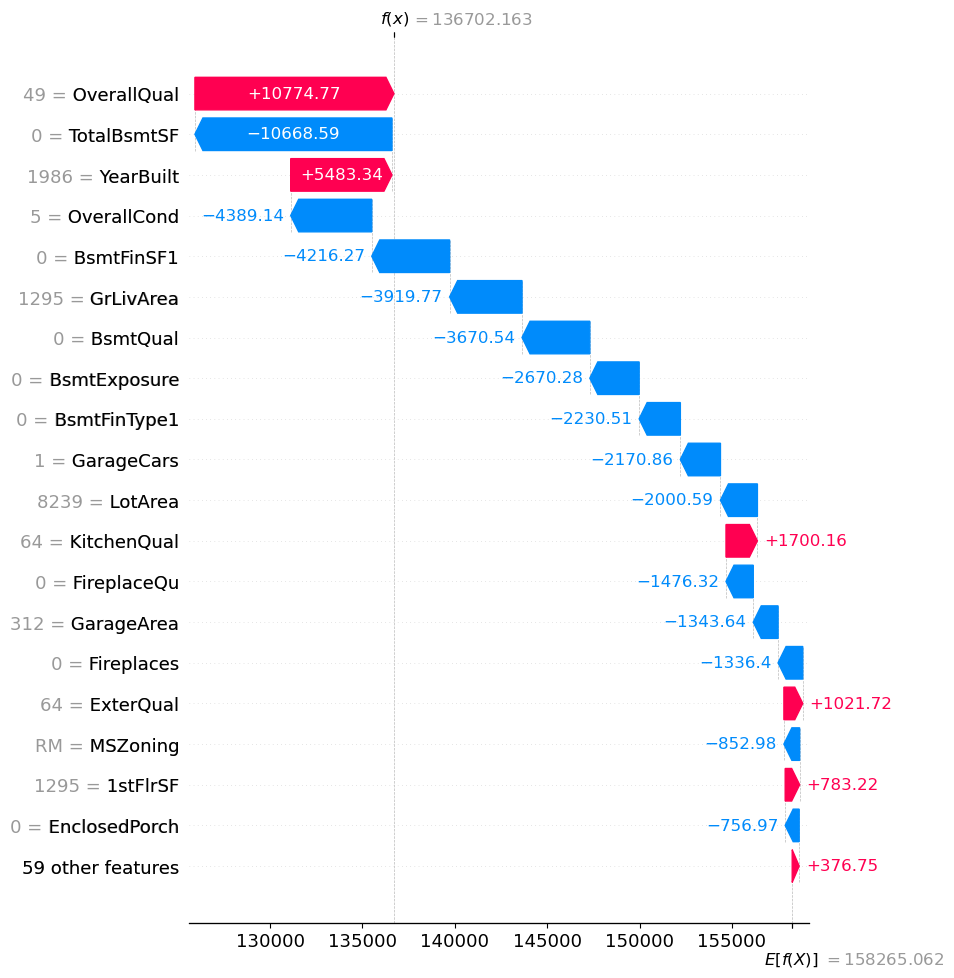

In [164]:
shap.waterfall_plot(exp_lasso_comb[530], max_display= 20)

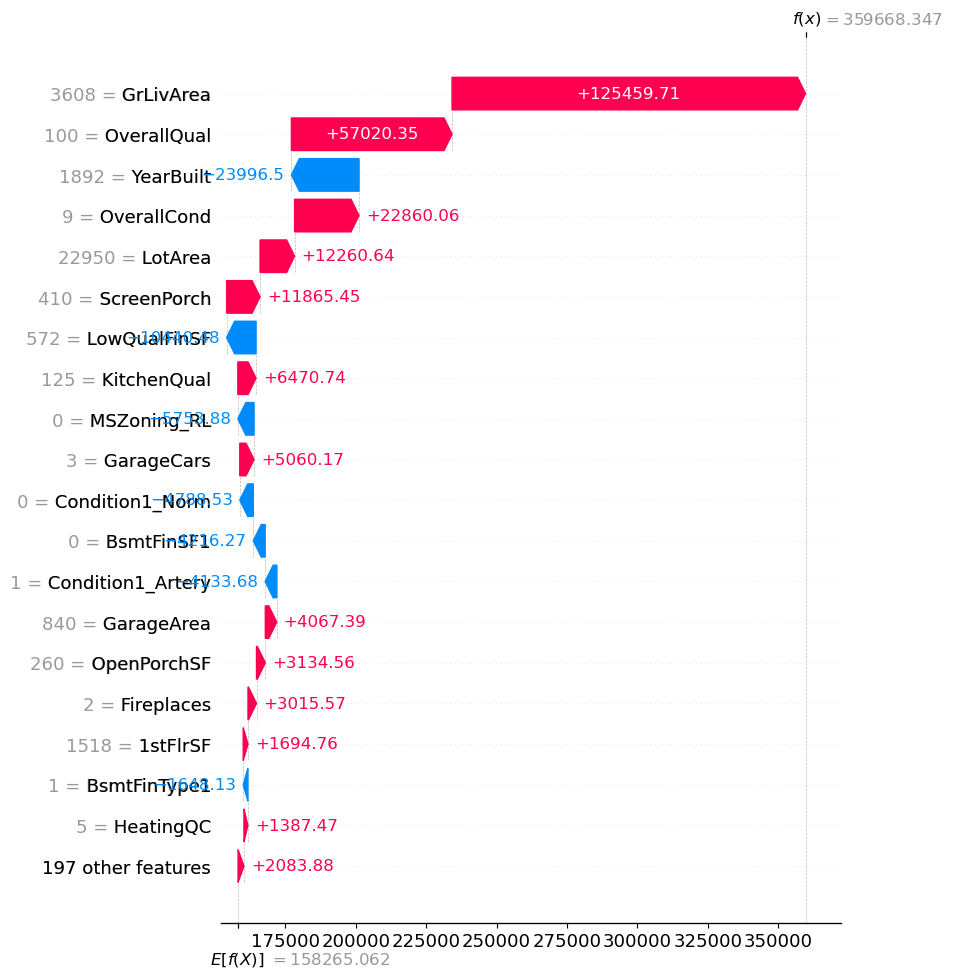

In [249]:
shap.waterfall_plot(exp_all_lasso[1777], max_display= 20)

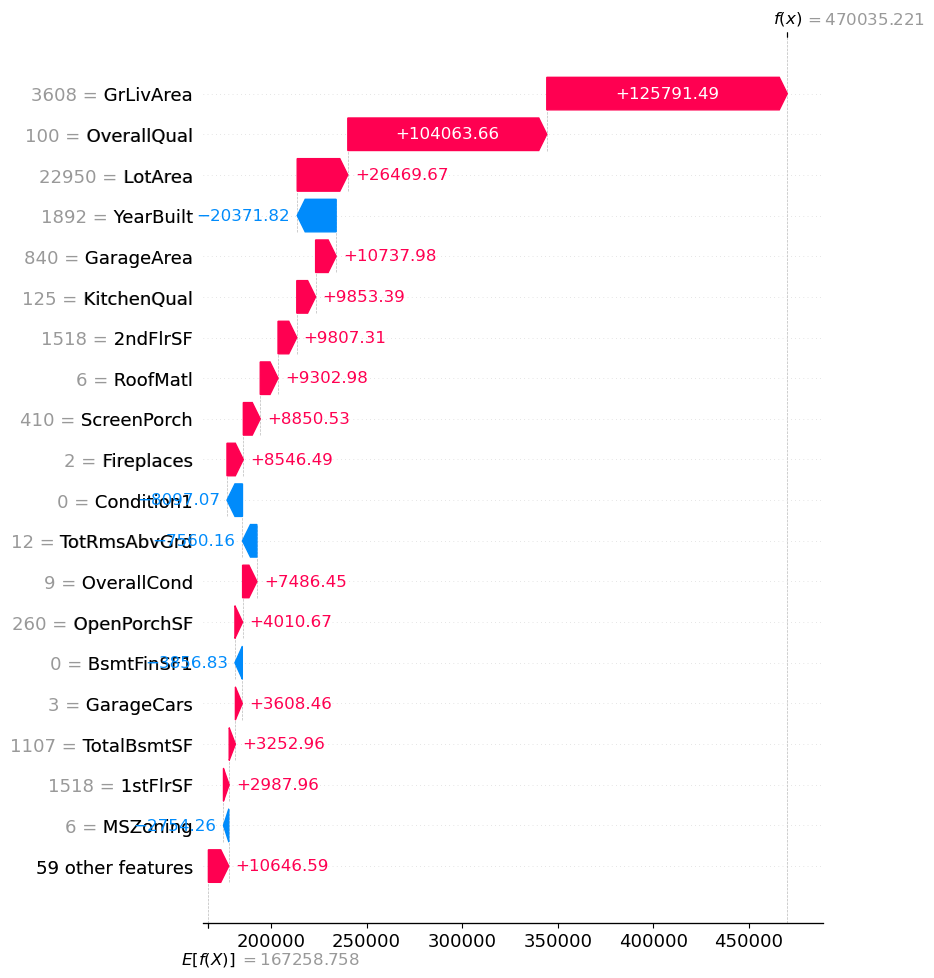

In [248]:
shap.waterfall_plot(exp_all_xgb_o[1777], max_display= 20)

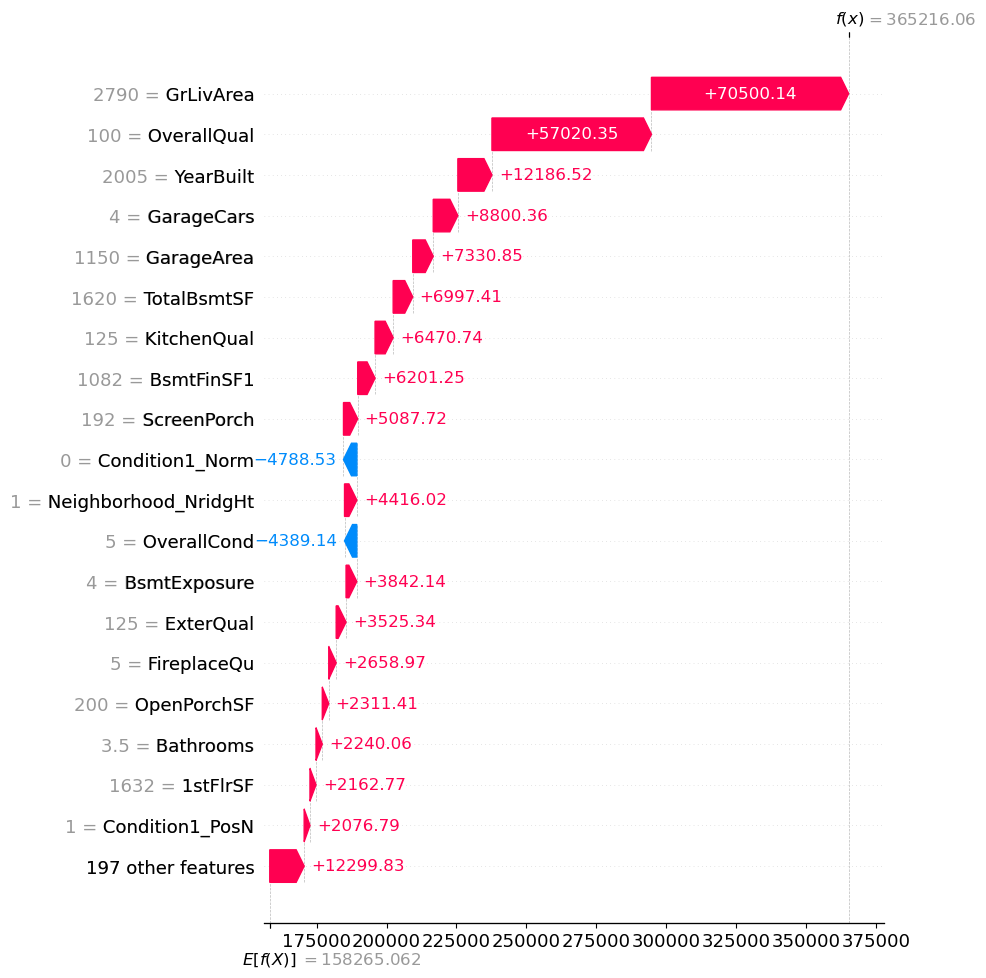

In [251]:
shap.waterfall_plot(exp_all_lasso[1897], max_display= 20)

IndexError: index 94 is out of bounds for axis 0 with size 78

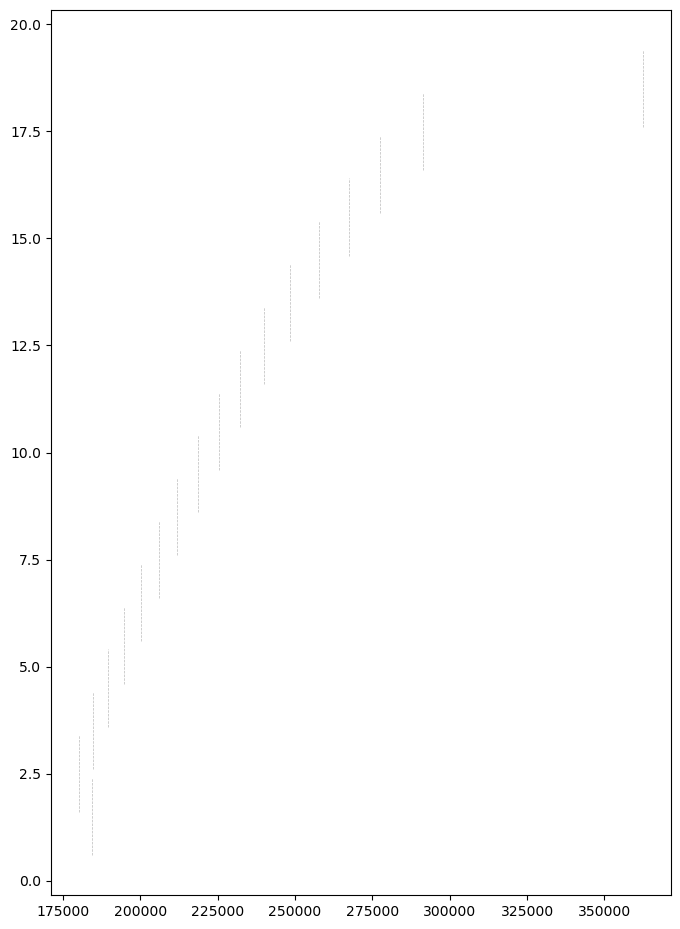

In [254]:
shap.waterfall_plot(exp_all_xgb_oh[1897], max_display= 20)

In [119]:
X.loc[X.Neighborhood== 'IDOTRR']

GrLivArea  MSSubClass MSZoning  LotFrontage  LotArea Street  Alley  \
2          1001          30  C (all)     60.00000     6060   Pave    0.0   
48          672          30       RM     61.00000     8534   Pave    0.0   
96         1355          70       RM     60.00000     6882   Pave    0.0   
99         1049          50  C (all)     52.00000     5150   Pave    0.0   
135        1154          50       RM     40.00000     5436   Pave    0.0   
...         ...         ...      ...          ...      ...    ...    ...   
2211       1200          50       RM     58.00000     8155   Pave    0.0   
2247        816          30       RM     46.63695     5890   Pave    0.0   
2248       1969          50       RM     60.00000     6876   Pave    0.0   
2277       1090          50       RM     60.00000     6000   Pave    0.0   
2320       1215          50       RM     50.00000     7000   Pave    0.0   

      LotShape  LandContour  Utilities  ... 3SsnPorch  ScreenPorch PoolYN  \
2            1            4          4  ...        86            0     no   
48           1            1          4  ...         0            0     no   
96           1            4          4  ...         0            0     no   
99           1            4          4  ...         0            0     no   
135          1            4          4  ...         0            0     no   
...        ...          ...        ...  ...       ...          ...    ...   
2211         1            4          4  ...         0            0     no   
2247         1            4          4  ...         0            0     no   
2248         1            3          4  ...         0            0     no   
2277         1            4          4  ...         0            0     no   
2320         1            4          4  ...         0            0     no   

     PoolQC  Fence MoSold YrSold  SaleType  SaleCondition  Bathrooms  
2       0.0     NO     11   2007       WD          Normal        1.0  
48      0.0   GdWo      6   2006       WD          Normal        1.0  
96      0.0     NO      3   2007       WD          Normal        1.5  
99      0.0     NO      5   2008       WD          Normal        1.0  
135     0.0  MnPrv      5   2010       WD          Normal        2.0  
...     ...    ...    ...    ...       ...            ...        ...  
2211    0.0     NO      7   2008       WD          Normal        1.0  
2247    0.0     NO      6   2008       WD          Normal        1.0  
2248    0.0     NO     11   2008       COD         Normal        2.0  
2277    0.0     NO      7   2008       WD          Normal        1.0  
2320    0.0  MnPrv      5   2007       WD          Normal        1.0  

[65 rows x 78 columns]

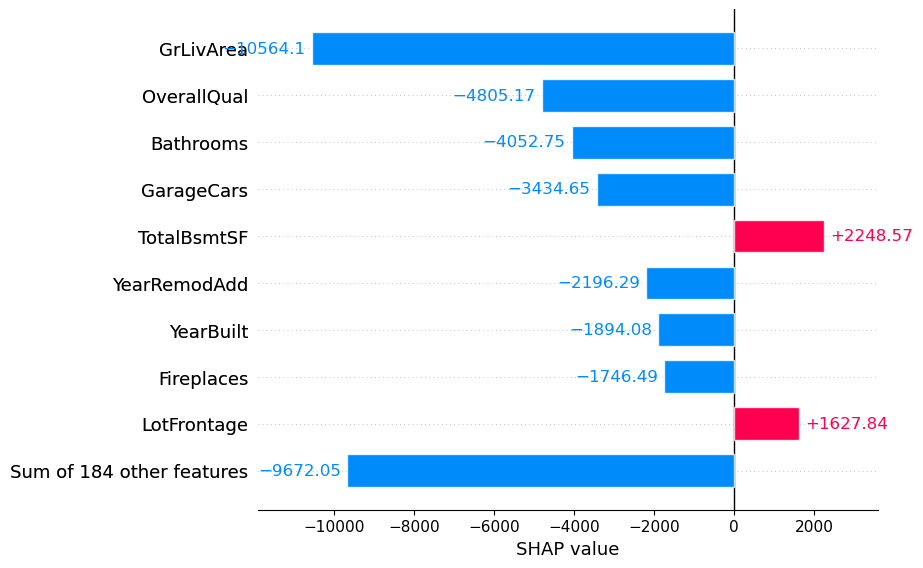

In [42]:
shap.plots.bar(exp_all_xgb_oh[100])

# Feature importance
### XGB tuned OrdinalEncoder

In [47]:
xgb_pipe_O.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#xgb_regressor = xgb_pipe.named_steps['Regressor'].regressor_
#feature_imp = xgb_regressor.feature_importances_
feature_imp = xgb_pipe_O.named_steps['XGB'].feature_importances_
# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_o = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance_xgb_o = feature_importance_xgb_o.sort_values(by='Importance', ascending=False)

feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('encoder__', '', regex=False)

feature_importance_xgb_o.head(20)

Feature  Importance
9    OverallQual    0.246695
41    GarageCars    0.121224
54     Bathrooms    0.067107
35   KitchenQual    0.042398
14     ExterQual    0.037956
0      GrLivArea    0.032138
38    Fireplaces    0.030368
72    GarageType    0.023609
24   TotalBsmtSF    0.023527
44    GarageCond    0.022935
42    GarageArea    0.020040
20    BsmtFinSF1    0.019388
26      1stFlrSF    0.017315
16      BsmtQual    0.016851
70    CentralAir    0.015045
39   FireplaceQu    0.013413
19  BsmtFinType1    0.009613
10   OverallCond    0.009495
11     YearBuilt    0.009427
45    PavedDrive    0.009385

In [222]:
xgb_predictions = xgb_pipe_O.predict(X)
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': xgb_predictions - y
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title='GrLivArea vs. Error',
    labels={'GrLivArea': 'GrLivArea (Square Feet)', 'Error': 'Prediction - Sale Price ($)', 'OverallQual': 'Overall Quality'}
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))

# Show plot
fig.show()


In [172]:
mae_xgb = mean_absolute_error(y, xgb_predictions)
mae_xgb

6331.731403035255

# SHAP xgb ordinal

In [50]:
explainer_xgb_o = shap.Explainer(xgb_pipe_O.named_steps['XGB'],
                          masker = xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_o = explainer_xgb_o(xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_o = pd.DataFrame(shap_values_xgb_o.values, columns=transformed_feature_names)

shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)


 95%|=================== | 2213/2333 [00:16<00:00]       

In [58]:
X_xgb_o = pd.DataFrame(xgb_pipe_O.named_steps['Preprocess'].transform(X))
X_xgb_o.columns = shap_values_df_xgb_o.columns
X_xgb_o[numerical_columns] = X[numerical_columns]
X_xgb_o

GrLivArea  MSSubClass  LotFrontage  LotArea  Alley  LotShape  \
0           856          30    62.472926     7890    0.0         1   
1          1049         120    42.000000     4235    0.0         1   
2          1001          30    60.000000     6060    0.0         1   
3          1039          70    80.000000     8146    0.0         1   
4          1665          60    70.000000     8400    0.0         1   
...         ...         ...          ...      ...    ...       ...   
2328        952          30    70.105866     8854    0.0         1   
2329       1733          20   108.318076    13680    0.0         2   
2330       2002          90    82.000000     6270    0.0         1   
2331       1842          60    69.884162     8826    0.0         1   
2332       1911          60    80.000000     9554    0.0         2   

      LandContour  Utilities  LandSlope  OverallQual  ...  Foundation  \
0               4          4          3           36  ...         1.0   
1               4          4          3           25  ...         1.0   
2               4          4          3           25  ...         0.0   
3               4          4          3           16  ...         0.0   
4               4          4          3           64  ...         2.0   
...           ...        ...        ...          ...  ...         ...   
2328            4          4          3           36  ...         0.0   
2329            4          4          3            9  ...         3.0   
2330            2          4          3           25  ...         1.0   
2331            4          4          3           49  ...         2.0   
2332            4          4          3           64  ...         2.0   

      Heating  CentralAir  Electrical  GarageType  GarageYN  PoolYN  Fence  \
0         1.0         1.0         3.0         5.0       1.0     0.0    4.0   
1         1.0         1.0         3.0         1.0       1.0     0.0    4.0   
2         1.0         1.0         3.0         5.0       1.0     0.0    4.0   
3         1.0         1.0         3.0         5.0       1.0     0.0    4.0   
4         1.0         1.0         3.0         1.0       1.0     0.0    4.0   
...       ...         ...         ...         ...       ...     ...    ...   
2328      3.0         0.0         1.0         5.0       1.0     0.0    4.0   
2329      1.0         1.0         0.0         1.0       1.0     0.0    4.0   
2330      1.0         0.0         0.0         0.0       1.0     0.0    4.0   
2331      1.0         1.0         3.0         1.0       1.0     0.0    4.0   
2332      1.0         1.0         3.0         1.0       1.0     0.0    4.0   

      SaleType  SaleCondition  
0          8.0            0.0  
1          8.0            0.0  
2          8.0            0.0  
3          8.0            0.0  
4          8.0            0.0  
...        ...            ...  
2328       8.0            0.0  
2329       8.0            0.0  
2330       8.0            0.0  
2331       8.0            0.0  
2332       8.0            0.0  

[2333 rows x 78 columns]

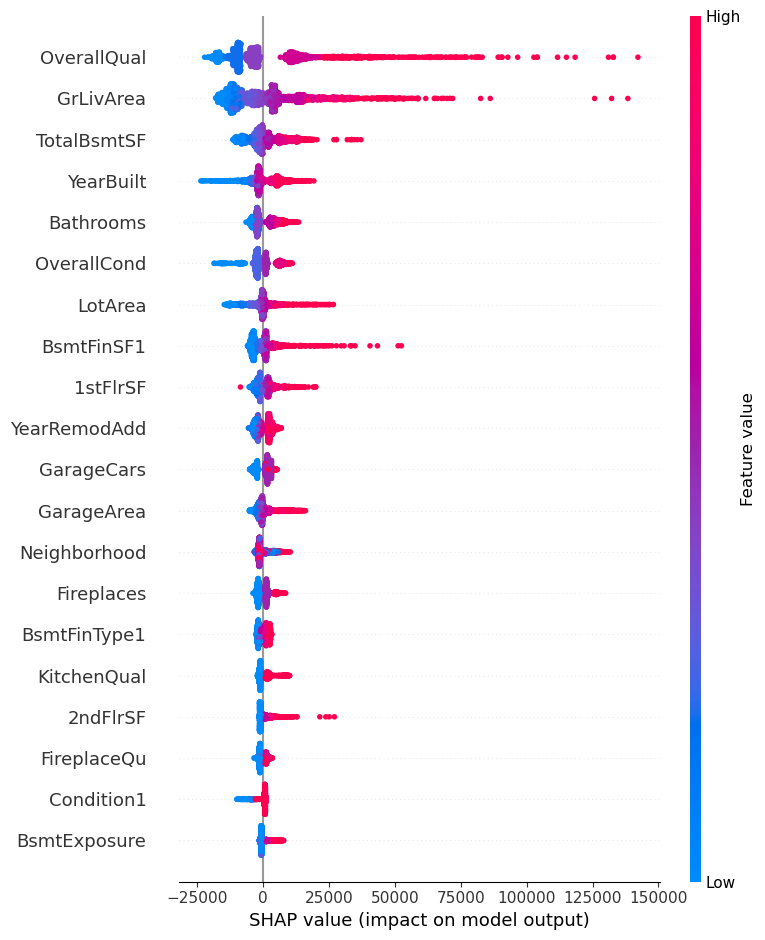

In [123]:
exp_all_xgb_o = shap.Explanation(shap_values_df_xgb_o.values, 
                           shap_values_xgb_o.base_values, 
                           X_xgb_o
                         )
shap.summary_plot(exp_all_xgb_o, 
                  max_display= 20)
# shap.summary_plot(exp_all_xgb_o, 
#                   max_display= 20, cmap= 'jet')

In [229]:
color = X.Neighborhood

color_transformed = []
for word in color:
    if word == 'Crawfor':
        color_transformed.append('Crawfor')
    elif word == 'StoneBr':
        color_transformed.append('StoneBr')
    elif word == 'BrkSide':
        color_transformed.append('BrkSide')
    else:
        color_transformed.append('other')
        

# color_transformed = []
# for word in color:
#     if word == 'Crawfor':
#         color_transformed.append('Crawfor')
#     elif word == 'StoneBr':
#         color_transformed.append('StoneBr')
#     elif word == 'BrkSide':
#         color_transformed.append('BrkSide')
#     elif word == 'Somerst':
#         color_transformed.append('Somerst')
#     elif word == 'ClearCr':
#         color_transformed.append('ClearCr')
#     else:
#         color_transformed.append('other')
        
#color = color.apply(lambda x: 'Crawfor' if x == 'Crawfor' else 'other')



In [227]:
fig = px.scatter(
    x=X.Neighborhood, 
    y=shap_values_df_xgb_o.Neighborhood, 
    color = np.sqrt(X.OverallQual),
    labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
    title='Neighborhood vs Neighborhood SHAP Values'
)

# Show the plot
fig.show()

In [228]:
fig = px.scatter(
    x=np.sqrt(X.OverallQual), 
    y=shap_values_df_xgb_o.OverallQual, 
    labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
    title='Overall Quality vs Neighborhood SHAP Values'
)

# Show the plot
fig.show()

In [217]:
fig = px.scatter(
    x=np.sqrt(X.OverallQual), 
    y= dollar_shap_values_lasso.OverallQual,
    labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
    title='Overall Quality vs Neighborhood SHAP Values'
)

# Show the plot
fig.show()

In [230]:
fig = px.scatter(
    x=np.sqrt(X.OverallQual), 
    y=shap_values_df_xgb_o.Neighborhood, 
    color = color_transformed,
    labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
    title='Overall Quality vs Neighborhood SHAP Values'
) 

# Show the plot
fig.show()

In [234]:
X.loc[X.Neighborhood == 'BrkSide'].YearBuilt.mean()

1932.0631578947368

In [240]:
X.loc[X.Neighborhood == 'BrkSide'].OverallCond.mean()

6.221052631578948

In [261]:
X.loc[X.Neighborhood == 'BrkSide'].OverallCond.mean()

6.221052631578948

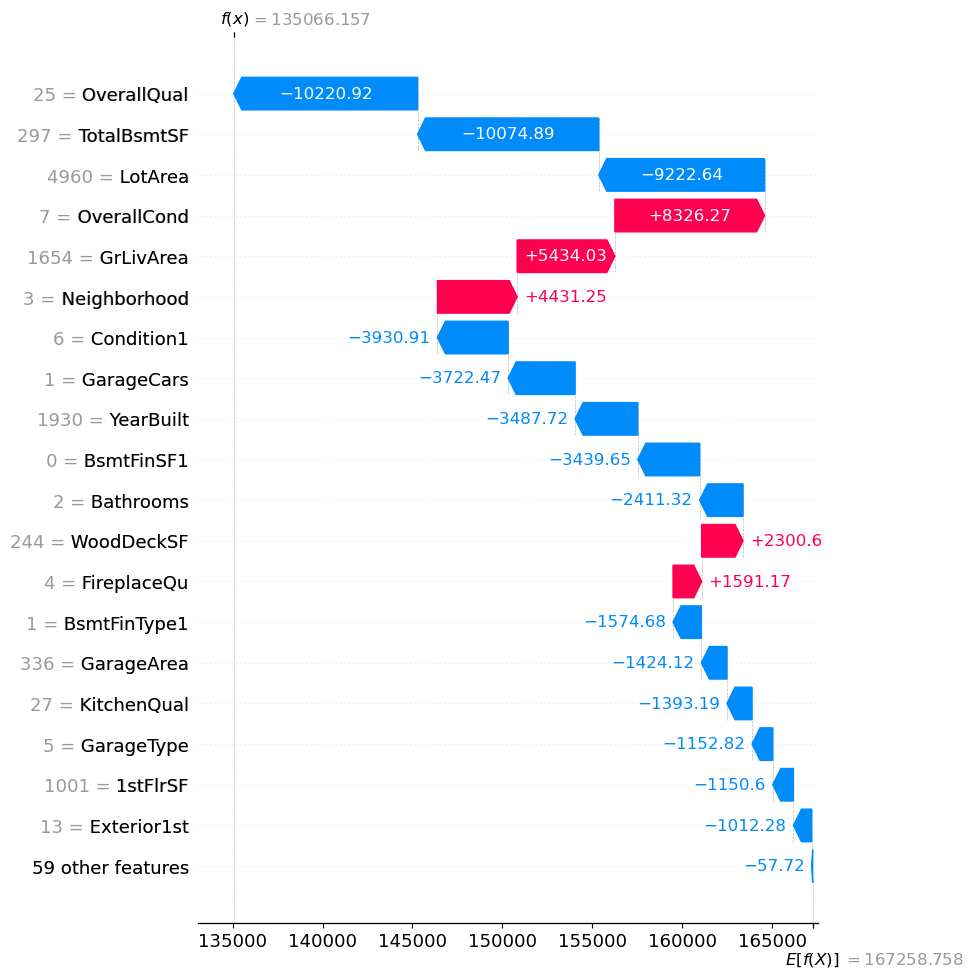

In [260]:
shap.waterfall_plot(exp_all_xgb_o[2299], max_display= 20)

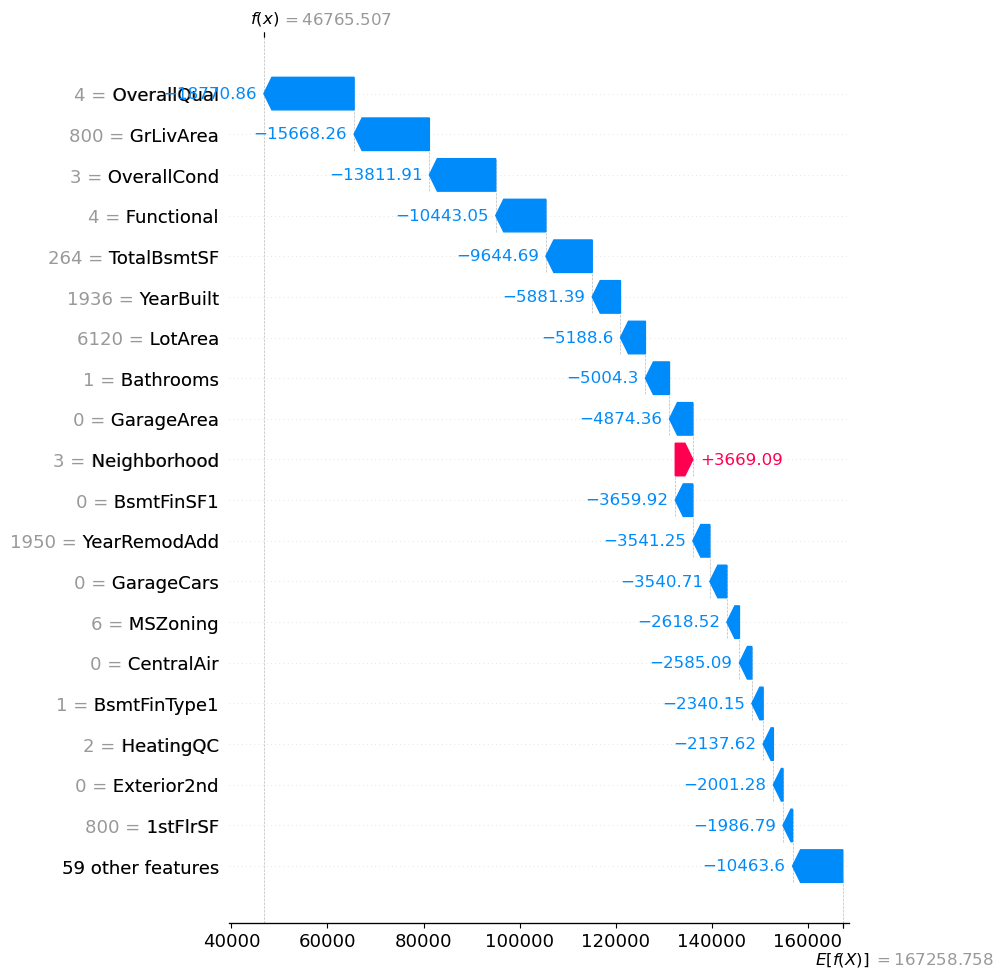

In [96]:
shap.waterfall_plot(exp_all_xgb_o[2035], max_display= 20)

In [255]:
fig = px.scatter(
    x= y, 
    y= predictions, 
    color = color_transformed,
    labels={'x': 'Sale Price', 'y': 'Prdicted Sale Price'},
    title='Sale Price vs. Predicted Sale Price'
)

# Show the plot
fig.show()

# Random Forest Tuned

In [145]:
categorical_preprocessor =  OrdinalEncoder(handle_unknown="use_encoded_value", 
                                           unknown_value= -1)
numerical_preprocessor = RobustScaler()

preprocessor = ColumnTransformer(
    [
        ("scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor, categorical_columns),
    ]
)

rf =  RandomForestRegressor( bootstrap = True, 
                            n_estimators = 338, 
                            max_depth = 73, 
                            min_samples_split = 4, 
                            min_samples_leaf = 2)

rf_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("RF", rf)])
# rf_pipe =Pipeline(steps=[("Preprocess", preprocessor),
#                            ("Regressor", TransformedTargetRegressor(regressor = rf,
#                                func =np.log, inverse_func=np.exp))])


scores = cross_val_score(rf_pipe, X, y, cv = kf, error_score='raise')

print('score', scores.mean())
print('standard deviation', scores.std())

score 0.9168119588723982
standard deviation 0.005402006979542654


In [146]:
rf_pipe.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#rf_regressor = rf_pipe.named_steps['Regressor'].regressor_
#feature_imp = rf_regressor.feature_importances_
feature_imp = rf_pipe.named_steps['RF'].feature_importances_
# Get the feature names after preprocessing


In [147]:
transformed_feature_names = rf_pipe.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


feature_importance['Feature'] = feature_importance['Feature'].str.replace('robust_scaler__', '', regex=False)
feature_importance['Feature'] = feature_importance['Feature'].str.replace('one-hot-encoder__', 'OHE__', regex=False)
feature_importance.head(20)

Feature  Importance
9     scaler__OverallQual    0.615071
0       scaler__GrLivArea    0.076659
42     scaler__GarageArea    0.066697
54      scaler__Bathrooms    0.052240
26       scaler__1stFlrSF    0.033455
24    scaler__TotalBsmtSF    0.033283
20     scaler__BsmtFinSF1    0.017043
3         scaler__LotArea    0.012455
41     scaler__GarageCars    0.008445
11      scaler__YearBuilt    0.006755
13     scaler__MasVnrArea    0.006075
2     scaler__LotFrontage    0.005020
12   scaler__YearRemodAdd    0.004282
27       scaler__2ndFlrSF    0.004022
23      scaler__BsmtUnfSF    0.003725
47    scaler__OpenPorchSF    0.003176
58  encoder__Neighborhood    0.003036
35    scaler__KitchenQual    0.002925
19   scaler__BsmtFinType1    0.002648
46     scaler__WoodDeckSF    0.002517

# Compare Lasso to XGB

In [209]:
# fig = px.scatter(
#     x=X.Neighborhood, 
#     y=shap_values_df_xgb_o.Neighborhood, 
#     color = np.sqrt(X.OverallQual),
#     labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
#     title='Overall Quality vs Neighborhood SHAP Values'
# )

# # Show the plot
# fig.show()
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.Neighborhood,
    y=shap_values_df_xgb_o.Neighborhood,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.Neighborhood,
    y= dollar_shap_values_lasso_comb.Neighborhood,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Neighborhood SHAP Values',
    xaxis=dict(title='Neighborhood'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [208]:
trace1 = go.Scatter(
    x=X.YearBuilt,
    y=shap_values_df_xgb_o.YearBuilt,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.YearBuilt,
    y= dollar_shap_values_lasso_comb.YearBuilt,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Year Built SHAP Values',
    xaxis=dict(title='Year Built'),
    yaxis=dict(title='SHAP Value'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [211]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=np.sqrt(X.OverallQual),
    y=shap_values_df_xgb_o.OverallQual,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= np.sqrt(X.OverallQual),
    y= dollar_shap_values_lasso_comb.OverallQual,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Overall Quality SHAP Values',
    xaxis=dict(title='Overall Quality'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [212]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x= X.GrLivArea,
    y=shap_values_df_xgb_o.GrLivArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GrLivArea,
    y= dollar_shap_values_lasso_comb.GrLivArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Living Area SHAP Values',
    xaxis=dict(title='Above Ground Living Area (Square Feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [225]:
lasso_predictions = lasso_pipe.predict(X)
lasso_mae = mean_absolute_error(y, lasso_predictions)
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': lasso_predictions - y
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'Lasso: Living Area vs. Prediction Error<br><sup>Mean Absolute Error: ${lasso_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Prediction - Sale Price ($)', 
            'color': 'Overall Quality'}
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))

# Show plot
fig.show()


In [245]:
xgb_predictions = xgb_pipe_O.predict(X)
xgb_mae = mean_absolute_error(y, xgb_predictions)
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': xgb_predictions - y
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'XGB: Living Area vs. Prediction Error<br><sup>Mean Absolute Error: ${xgb_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Prediction - Sale Price ($)', 
            'color': 'Overall Quality'}
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))

fig.update_layout(
    yaxis_range=[-100000, 100000]
)

# Show plot
fig.show()

In [ ]:
fig = px.scatter(
    x=X.Neighborhood, 
    y=shap_values_df_xgb_o.Neighborhood, 
    color = np.sqrt(X.OverallQual),
    labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
    title='Overall Quality vs Neighborhood SHAP Values'
)

# Show the plot
fig.show()